In [2]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import sounddevice as sd
import soundfile as sf

## Exercise 9.1

In [3]:
# Simulation parameters
m = 8               # no. of mics
delta = 0.0425      # microphone spacing
fs = 8e3            # sampling frequency
c = 340             # propagation speed of sound

# some auxiliary values
n = 256             #frame size

In [4]:
# load signals
f = np.load('signals_09.npz')
S = f['S']
Noise = f['Noise']
fs = 8000
xM = S + Noise

In [5]:
print(S.shape)
sd.play(S[:,4],fs)
print(np.argmax(np.mean(S,0)))
print(np.argmax(np.mean(xM,0)))

(60000, 8)
0
7


In [6]:
def compute_incident_angle(sig_in):
    '''
    Compute the incindent angle of the signal at the beamformer, using the delay between the first
    and the last microphone in the array.
    '''
    global m, c, delta
    # todo: calculate direction of sound incidence
    #compute the cross-correlation between the first and last microphone signals
    xcorr = signal.correlate(sig_in[:,0], sig_in[:,-1], mode='full')
    print("xcorr.shape: ",xcorr.shape)
    #lags = signal.correlation_lags(len(sig_in[:,0]), len(sig_in[:,-1]), mode='full')
    lag = np.argmax(xcorr) - len(sig_in[:,0]+1)

    #find the index of the maximum correlation
    #max_lag_index = np.argmax(np.abs(xcorr))
    #max_lag = lags[max_lag_index]

    #compute time delay
    time_delay = lag / fs
    print("Time delay: ",time_delay)
    
    #compute incident angle
    angle_rad = np.arcsin((time_delay * c) / ((m - 1) * delta))
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg

print("Incident angle of speech is {:4.2f} degrees".format(compute_incident_angle(S)))
print("Incident angle of noise is {:4.2f} degrees".format(compute_incident_angle(Noise)))

xcorr.shape:  (119999,)
Time delay:  -0.000125
Incident angle of speech is -8.21 degrees
xcorr.shape:  (119999,)
Time delay:  -0.00075
Incident angle of noise is -59.00 degrees


In [50]:
# todo: apply DS-BF
def delay_and_sum_beamformer(sig_in, angle_speech):
    '''
    Apply delay-and-sum beamforming to the input signals.
    :param sig_in:         input (noisy) signal
    :param angle_speech:       detected angle of speech
    :return: y (filtered signal), s_filt (filtered (lost) speech signal),v_ (remaining noise signal)
    '''
    global m, c, delta, fs
    
    #convert angle to radians
    angle_speech_rad = np.radians(angle_speech)
    
    #calculate delays in samples
    delays_speech = np.arange(m) * delta * np.sin(angle_speech_rad) / c *fs
    print("Delays_speech: ",delays_speech)
    
    #delay signals and sum them up for speech and noise separately
    y = np.zeros_like(sig_in[:,0])
    for i in range(m):
        y += np.roll(sig_in[:,i], -int(delays_speech[i])) #negative roll, because speech signal at further mics is late
    
    s_filt = np.sum(S,axis=1)-y #substract filtered signal from clean speech signal
    v_ = np.sum(xM,axis=1)-y #substract filtered signal from noisy signal to get remaining noise
    y = y / max(np.abs(y)) #normalize y
    
    return y, s_filt, v_

In [42]:
# Perform noise reduction
speech_angle = compute_incident_angle(S)
noise_angle = compute_incident_angle(Noise)
#y(k)=output,sˉ(k)=filtered speech, vˉ(k)=noise signal
y, s_filt, v_ = delay_and_sum_beamformer(xM, speech_angle)
print(y.shape)
#sd.play(xM[:,0],fs)
sd.play(y,fs)

xcorr.shape:  (119999,)
Time delay:  -0.000125
xcorr.shape:  (119999,)
Time delay:  -0.00075
Delays_speech:  [-0.         -0.14285714 -0.28571429 -0.42857143 -0.57142857 -0.71428571
 -0.85714286 -1.        ]
(60000,)


In [116]:
sd.play(y,fs)
#sd.play(xM[:,0],fs)

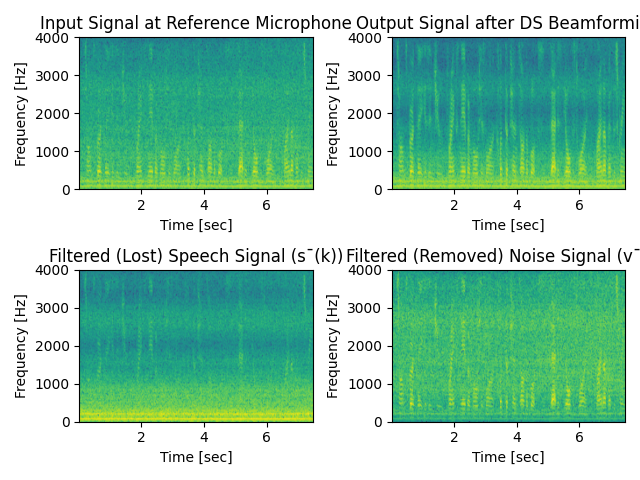

In [43]:
#todo: Plot results
# use same color limits for both plots.
clims = dict(vmin=-120, vmax=-40)
# Plot spectrograms
def plot_spectrogram(ax, sig, title, fs):
    f, t, Sxx = signal.spectrogram(sig, fs)
    ax.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(title)
    #ax.set_colorbar(label='dB')
    #plt.show()
    #cbar = plt.colorbar(ax=ax.collections[0])
    #cbar.set_label('Intensity [dB]')

# Plot spectrogram of input signal at the first microphone
fig,ax = plt.subplots(2,2)

plot_spectrogram(ax[0,0],xM[:,0], 'Input Signal at Reference Microphone', fs)

# Plot spectrogram of output signal
plot_spectrogram(ax[0,1],y, 'Output Signal after DS Beamforming', fs)

# Plot spectrogram of filtered speech signal
plot_spectrogram(ax[1,0],s_filt, 'Filtered (Lost) Speech Signal (s¯(k))', fs)

# Plot spectrogram of filtered noise signal
plot_spectrogram(ax[1,1],v_, 'Filtered (Removed) Noise Signal (v¯(k))', fs)
plt.tight_layout()
#spectrograms make sense, output signal after beamforming looks noticeably cleaner, but also some speech is lost

In [148]:
# play signals
#sd.play(S[:,0],fs) #clean speech
#sd.play(xM[:,0],fs) #noisy speech
sd.play(y,fs) #filtered speech, sounds better than unfiltered, but not perfect, there is still noise left

## Exercise 9.2

In [58]:
# Three helper functions
def glob_snr(sig, noise):
    """
    returns the global SNR between sig and noise in dB.
    :param sig:         clean signal
    :param noise:       noise signal
    :return: the global SNR in dB
    """
    global_snr_db = 10 * np.log10(np.sum(sig ** 2) / np.sum(noise ** 2))
    return global_snr_db


def noise_attenuation(reference, filtered, blocklength):
    """
    returns the noise attenuation between sig and noise in dB.
    :param reference:      noise at the microphone
    :param filtered:       filtered noise signal
    :param blocklength:    frame/block length
    :return: the Noise Attenuation in dB
    """
    global n
    num_blocks = len(reference) // blocklength
    na_values = []
    
    for i in range(num_blocks):
        ref_block = reference[i * blocklength:(i + 1) * blocklength]
        filt_block = filtered[i * blocklength:(i + 1) * blocklength]
        
        ref_power = np.sum(ref_block ** 2)
        filt_power = np.sum(filt_block ** 2)
        
        na = ref_power / filt_power
        #print("na value: ", na)
        na_values.append(na)
    
    return 10*np.log10(np.mean(na_values))



def scale4snr(sig, noise, snr_wanted):
    """
    returns the scaling factor for the noise to obtain wanted global SNR in dB.
    :param sig:         clean signal
    :param noise:       noise signal
    :param snr_wanted:   desired global SNR in dB
    :return: scalar scaling factor a, so that sig + a*noise has the snr_wanted snr
    """
    #calculate scaling factor a
    #snr = 10*np.log10(np.sum(sig ** 2) / np.sum(noise ** 2))
    #a = np.sqrt(np.sum(sig ** 2) / np.sum(noise ** 2)) * 10 ** (-snr_wanted / 20)
    power_sig = np.mean(sig**2)
    power_noise = np.mean(noise**2)
    
    #calculate the target noise power
    target_noise_power = power_sig / (10**(snr_wanted / 10))
    
    #calculate scaling factor for the noise
    a = np.sqrt(target_noise_power / power_noise)
    
    return a

SNR  -10 db, Noise scaling_factor:  3.16227766016838
xcorr.shape:  (119999,)
Time delay:  -0.00075
Delays_speech:  [-0.         -0.85714286 -1.71428571 -2.57142857 -3.42857143 -4.28571429
 -5.14285714 -6.        ]
SNR  -5 db, Noise scaling_factor:  1.7782794100389234
xcorr.shape:  (119999,)
Time delay:  -0.00075
Delays_speech:  [-0.         -0.85714286 -1.71428571 -2.57142857 -3.42857143 -4.28571429
 -5.14285714 -6.        ]
SNR  0 db, Noise scaling_factor:  1.0000000000000002
xcorr.shape:  (119999,)
Time delay:  -0.000125
Delays_speech:  [-0.         -0.14285714 -0.28571429 -0.42857143 -0.57142857 -0.71428571
 -0.85714286 -1.        ]
SNR  5 db, Noise scaling_factor:  0.5623413251903493
xcorr.shape:  (119999,)
Time delay:  -0.000125
Delays_speech:  [-0.         -0.14285714 -0.28571429 -0.42857143 -0.57142857 -0.71428571
 -0.85714286 -1.        ]
SNR  10 db, Noise scaling_factor:  0.31622776601683805
xcorr.shape:  (119999,)
Time delay:  -0.000125
Delays_speech:  [-0.         -0.1428571

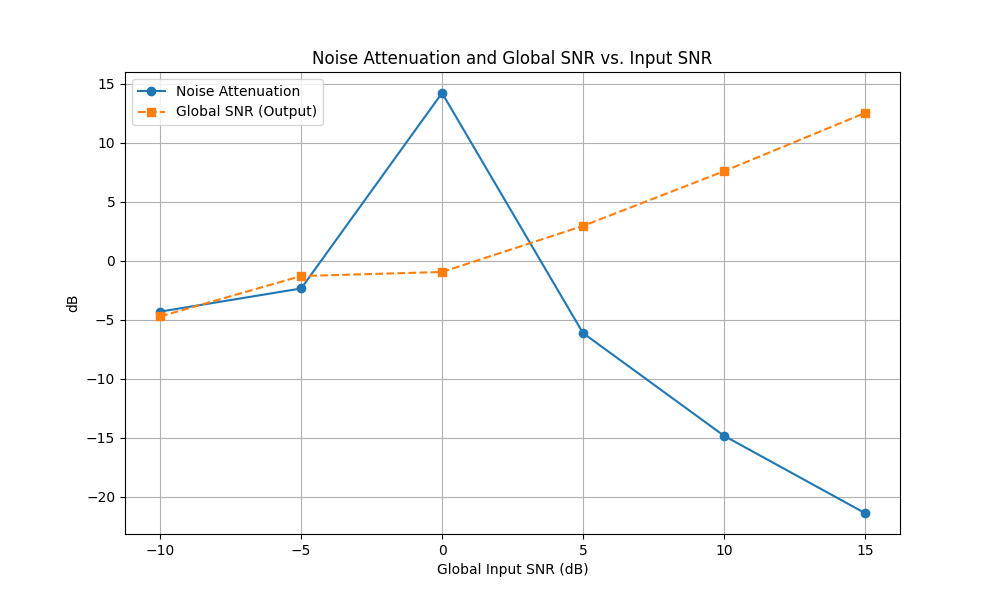

In [59]:
def sweep_snr(sig, noise):
    global m, n
    na = []
    snr_out = []
    snr_in = []
    snr_levels = [-10, -5, 0, 5, 10, 15]

    for snr in snr_levels:
        # Scale noise signal to achieve desired SNR
        scaling_factor = scale4snr(sig[:,0], noise[:,0], snr)
        print("SNR ",snr,"db, Noise scaling_factor: ", scaling_factor)
        vn = scaling_factor * noise

        # Mix signals: speech + scaled noise
        x = sig + vn

        # Apply Delay-and-Sum Beamforming
        y, s_filt, v_ = delay_and_sum_beamformer(x,compute_incident_angle(x))

        # Compute Noise Attenuation
        noise_att = noise_attenuation(vn, v_, blocklength=n)
        
        # Compute global SNR at the output
        snr_out_glob = glob_snr(y, vn)

        na.append(noise_att)
        snr_out.append(snr_out_glob)
        snr_in.append(snr)

    # todo: plot results
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(snr_in, na, marker='o', linestyle='-', label='Noise Attenuation')
    plt.plot(snr_in, snr_out, marker='s', linestyle='--', label='Global SNR (Output)')
    plt.xlabel('Global Input SNR (dB)')
    plt.ylabel('dB')
    plt.title('Noise Attenuation and Global SNR vs. Input SNR')
    plt.legend()
    plt.grid(True)
    plt.show()

sweep_snr(S, Noise)

## Exercise 9.3

SNR  -10 db, Noise scaling_factor:  0.15546554270199728
xcorr.shape:  (119999,)
Time delay:  -0.000125
Delays_speech:  [-0.         -0.14285714 -0.28571429 -0.42857143 -0.57142857 -0.71428571
 -0.85714286 -1.        ]
SNR  -5 db, Noise scaling_factor:  0.08742469930447795
xcorr.shape:  (119999,)
Time delay:  -0.000125
Delays_speech:  [-0.         -0.14285714 -0.28571429 -0.42857143 -0.57142857 -0.71428571
 -0.85714286 -1.        ]
SNR  0 db, Noise scaling_factor:  0.04916252126124792
xcorr.shape:  (119999,)
Time delay:  -0.000125
Delays_speech:  [-0.         -0.14285714 -0.28571429 -0.42857143 -0.57142857 -0.71428571
 -0.85714286 -1.        ]
SNR  5 db, Noise scaling_factor:  0.02764611735574887
xcorr.shape:  (119999,)
Time delay:  -0.000125
Delays_speech:  [-0.         -0.14285714 -0.28571429 -0.42857143 -0.57142857 -0.71428571
 -0.85714286 -1.        ]
SNR  10 db, Noise scaling_factor:  0.015546554270199728
xcorr.shape:  (119999,)
Time delay:  -0.000125
Delays_speech:  [-0.         -

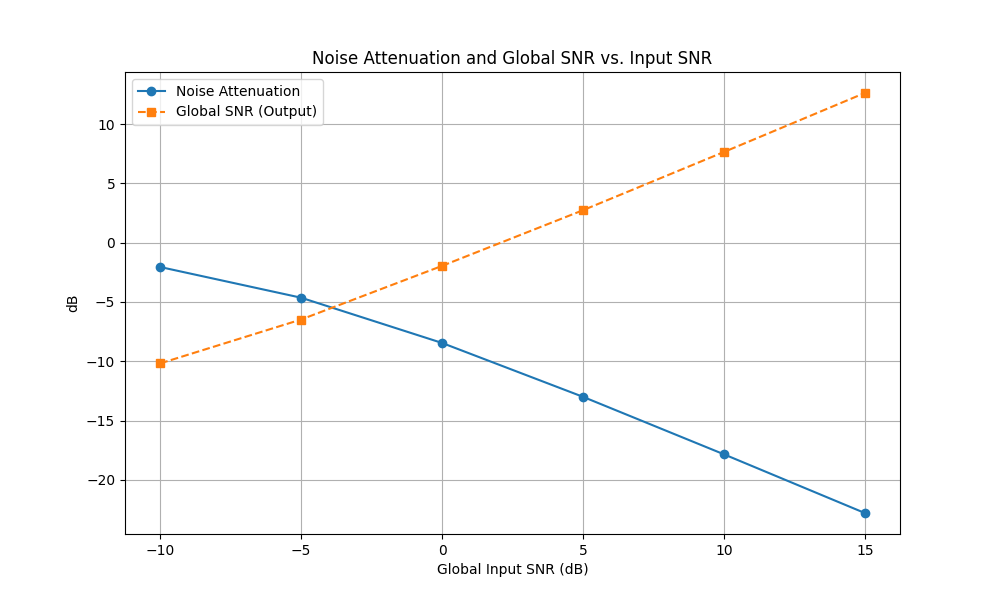

In [60]:
# todo: generate white noise
N_uncorr = np.random.normal(loc=0, scale=1, size=S.shape)
sweep_snr(S, N_uncorr)
# with increasing global SNR the beamformer uniformly removes a decreasing amount of noise,
# unlike the previous experiment where we saw a sweet spot with 0dB input SNR

## Exercise 9.4

In [64]:
import scipy.io.wavfile as wav
sample_rate, data = wav.read('autonoise.wav')
print("Sample Rate:", sample_rate)
print("Data Shape:", data.shape)
print("Data Type:", data.dtype)
sd.play(data,sample_rate)

Sample Rate: 8000
Data Shape: (65536,)
Data Type: int16


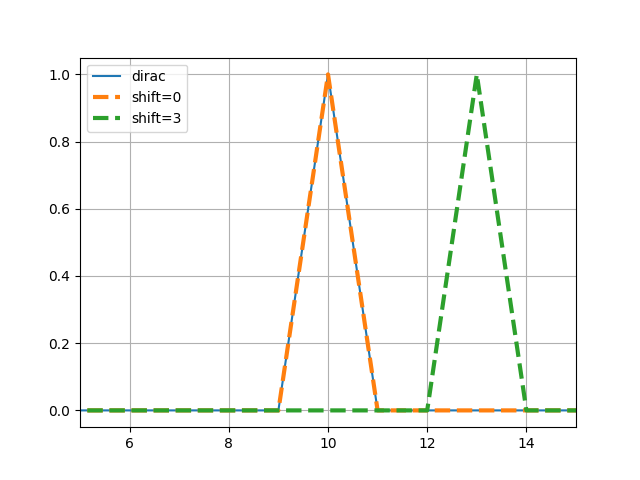

In [79]:
from scipy.signal import firwin, lfilter
def fracdel(inp, delay, n=256):
    """
    returns input sequence delayed by delta samples, which can be fractional value. This is achieved by means of a
    fractional-delay filter of degree 2*n. The output sequence y is of the same length as the input sequence in.
    :param inp:     input sequence
    :param delay:   time delay
    :param n:       filter length
    :return:        convolved sequence
    """
    # Generate the sinc filter
    t = np.arange(-n, n + 1)
    sinc_filter = np.sinc(t - delay)
    
    # Apply a window to the sinc filter (Hamming window is used here)
    #window = np.hamming(2 * n + 1)
    #filter_coeffs = sinc_filter * window
    
    # Normalize the filter coefficients
    #filter_coeffs /= np.sum(filter_coeffs)
    sinc_filter /= np.sum(sinc_filter)
    
    # Convolve the input signal with the fractional delay filter
    delayed_signal = np.convolve(inp, sinc_filter, mode='same')
    
    return delayed_signal

# quick test for fracdel
dirac = np.zeros(1000)
dirac[10] = 1

shifted0 = fracdel(dirac, 0)
shifted3 = fracdel(dirac, 3)

_, axis = plt.subplots(1,1)
axis.plot(dirac)
axis.plot(shifted0, '--', linewidth=3)
axis.plot(shifted3, '--', linewidth=3)
axis.set_xlim((5, 15))
axis.grid()
axis.legend(('dirac', 'shift=0', 'shift=3'))

In [ ]:
# todo: load car noise
carnoise = ...

def sweep_angle(sig, noise):
    global m, delta, c, fs

    # todo: sweep angle, apply DS-BF and evaluate metrics
    pass

sweep_angle(S, carnoise)